In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from src.CP_VQA.Qulacs_CP_VQA import Qulacs_CP_VQA
from src.QAOA_HYBRID.Qulacs_QAOA_HYBRID import Qulacs_QAOA_HYBRID
from src.QAOA.Qulacs_QAOA import Qulacs_QAOA

from src.Chain import Chain
from src.Qubo import Qubo
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       check_qubo)

In [2]:
def simulate(settings: dict):
    # Generating random problem instance 
    expected_returns, covariances = portfolio_metrics(n=settings['N'], seed=settings['seed'])
    # Retrieving C_min, C_max and corresponding states for original portfolio problem
    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=settings['N'],
                                                                k=settings['k'],
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=settings['alpha'])

    # Generating QUBO corresponding to current problem instance
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances, 
                         alpha=settings['alpha'],
                         lmbda=lmbda+1, # Adding small constant purposely
                         k=settings['k'])
    qubo = Qubo(Q=Q, offset=offset) 
    qubo.subspace_c_min, qubo.subspace_c_max = constrained_result['c_min'], constrained_result['c_max']
    qubo.subspace_x_min, qubo.subspace_x_max = constrained_result['s_min'], constrained_result['s_max']
    qubo.full_space_c_min, qubo.full_space_c_max = full_result['c_min'], full_result['c_max']
    check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=settings['alpha'], k=settings['k'])
     
    
    qaoa = Qulacs_QAOA(N_qubits=settings['N'],
                       cardinality=settings['k'],
                       layers=settings['L'],
                       qubo=qubo)
    
    
    cp_vqa = Qulacs_CP_VQA(N_qubits=settings['N'],
                           cardinality=settings['k'],
                           layers=settings['L'],
                           topology=settings['topology'],
                           get_full_state_vector=False,
                           with_next_nearest_neighbors=settings['w_nnn'],
                           qubo=qubo)
    
    qaoa_hybrid = Qulacs_QAOA_HYBRID(N_qubits=settings['N'],
                           cardinality=settings['k'],
                           layers=settings['L'],
                           topology=settings['topology'],
                           get_full_state_vector=False,
                           with_next_nearest_neighbors=settings['w_nnn'],
                           qubo=qubo)
    
     
    
     # Generating initial guess for rotation angles
    np.random.seed(settings['seed'])
    theta_min, theta_max = -2*np.pi, 2*np.pi
    N_angles = settings['L'] * len(settings['topology'].get_NNN_indices()) if settings['w_nnn'] else settings['L'] * len(settings['topology'].get_NN_indices())
    CPVQA_theta_i = np.random.uniform(theta_min, theta_max, N_angles)
    QAOA_theta_i = np.random.uniform(theta_min, theta_max, 2*settings['L'])
    
    
    qaoa_sim_res = sc.optimize.minimize(fun=qaoa.get_cost, 
                                        x0=QAOA_theta_i,
                                        method=settings['opt_method'],
                                        options={'disp': False, 
                                                 'maxiter': settings['max_iter']},
                                        callback=qaoa.callback)
    qaoa_norm_c = np.min(qaoa.normalized_costs)
    qaoa_p = np.max(qaoa.opt_state_probabilities)    
    
    
    cp_vqa_sim_res = sc.optimize.minimize(fun=cp_vqa.get_cost, 
                                          x0=CPVQA_theta_i,
                                          method=settings['opt_method'],
                                          options={'disp': False, 
                                                   'maxiter': settings['max_iter']},
                                          callback=cp_vqa.callback)
    cp_vqa_norm_c = np.min(cp_vqa.normalized_costs)
    cp_vqa_p = np.max(cp_vqa.opt_state_probabilities)
    
    
    qaoa_hybrid_sim_res = sc.optimize.minimize(fun=qaoa_hybrid.get_cost, 
                                          x0=QAOA_theta_i,
                                          method=settings['opt_method'],
                                          options={'disp': False, 
                                                   'maxiter': settings['max_iter']},
                                          callback=qaoa_hybrid.callback)
    qaoa_hybrid_norm_c = np.min(qaoa_hybrid.normalized_costs)
    qaoa_hybrid_p = np.max(qaoa_hybrid.opt_state_probabilities)
    
    return  {'N':settings['N'],
             'CP_VQA': {'c':cp_vqa_norm_c,'p':cp_vqa_p},
             'QAOA': {'c':qaoa_norm_c,'p':qaoa_p},
             'QAOA_HYBRID': {'c':qaoa_hybrid_norm_c,'p':qaoa_hybrid_p}}

In [3]:
layer_dict = {2:1,  3:1,  4:1,
              5:2,  6:2,  7:3,
              8:5,  9:6,  10:6,
              11:5, 12:5, 13:5,
              14:5, 15:5, 16:5,
              17:6, 18:6, 19:6, 
              20:7, 21:7, 22:7}

max_iter_dict = {2: 400,   3:  400,  4:  500,
                 5: 600,   6:  800,  7:  900,
                 8: 1000,  9:  1100, 10: 1200,
                 11: 1300, 12: 1400, 13: 1500,
                 14: 1500, 15: 1500, 16: 2000,
                 17: 2000, 18: 2000, 19: 2000,
                 20: 2000, 21: 2000, 22: 2000}

max_iter = 1500
alpha=0.5
N_seeds = 100
N_min, N_max = 2,12
sim_settings = []
for seed in range(N_seeds):
    for N in range(N_min, N_max+1):
        topology = Chain(N_qubits=N)
        topology.set_initialization_strategy(strategy=np.array([0 if i%2 == 0 else 1 for i in range(N)]))
        setting = {'N'         :N,       'alpha'   :alpha,   'L'       :layer_dict[N], 
                   'seed'      :seed,    'topology':topology,'max_iter':max_iter_dict[N],
                   'opt_method':'COBYLA','w_nnn'   :True,    'k'       :N//2}
        sim_settings.append(setting)

In [ ]:
N_jobs=15
r = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(setting) for setting in sim_settings)


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=15)]: Done   3 tasks      | elapsed:    2.2s
[Parallel(n_jobs=15)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=15)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=15)]: Done   6 tasks      | elapsed:    2.3s
[Parallel(n_jobs=15)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=15)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=15)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=15)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    2.7s
[Parallel(n_jobs=15)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=15)]: Done  13 tasks      | elapsed:    3.1s
[Parallel(n_jobs=15)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=15)]: Done  15 tasks      | elapsed:  

In [33]:
N_vals = [N for N in range(N_min,N_max+1)]
qaoa_res, cp_vqa_res, qaoa_hybrid_res = {N:[] for N in N_vals}, {N:[] for N in N_vals}, {N:[] for N in N_vals}
for result in r:
    qaoa_res[result['N']].append([result['QAOA']['c'],result['QAOA']['p']])
    cp_vqa_res[result['N']].append([result['CP_VQA']['c'],result['CP_VQA']['p']])
    qaoa_hybrid_res[result['N']].append([result['QAOA_HYBRID']['c'],result['QAOA_HYBRID']['p']])

In [34]:
def exponential_decay(x):
    return 1.0 / (2**(x-1))

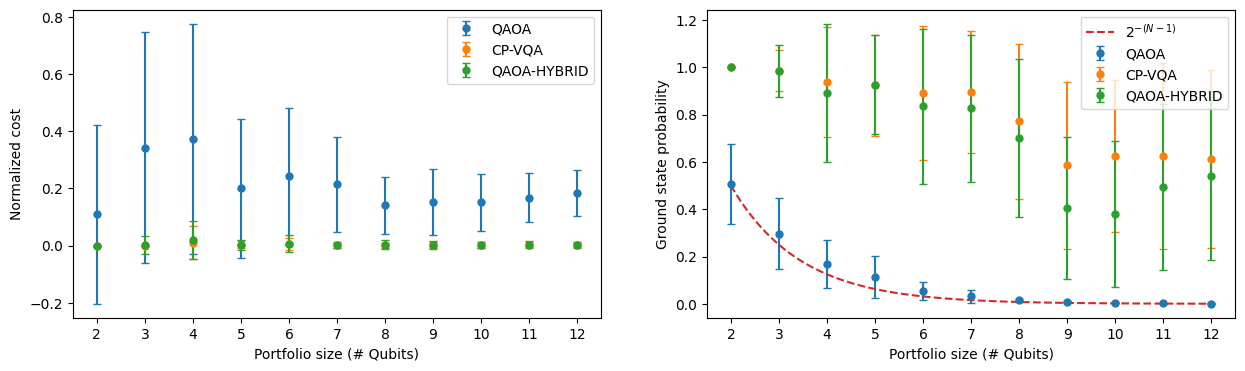

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
N_vales = [N for N in range(N_min,N_max+1)]
ax[0].errorbar(N_vales, [np.mean(np.array(qaoa_res[N])[:,0]) for N in N_vales], [np.std(np.array(qaoa_res[N])[:,0]) for N in N_vales], 
               label='QAOA', capsize=3, fmt='.', ms=10)

ax[0].errorbar(N_vales, [np.mean(np.array(cp_vqa_res[N])[:,0]) for N in N_vales], [np.std(np.array(cp_vqa_res[N])[:,0]) for N in N_vales], label='CP-VQA', capsize=3, fmt='.', ms=10)

ax[0].errorbar(N_vales, [np.mean(np.array(qaoa_hybrid_res[N])[:,0]) for N in N_vales], [np.std(np.array(qaoa_hybrid_res[N])[:,0]) for N in N_vales], label='QAOA-HYBRID', capsize=3, fmt='.', ms=10)

ax[1].errorbar(N_vales, [np.mean(np.array(qaoa_res[N])[:,1]) for N in N_vales], [np.std(np.array(qaoa_res[N])[:,1]) for N in N_vales], label='QAOA', capsize=3, fmt='.', ms=10)
ax[1].errorbar(N_vales, [np.mean(np.array(cp_vqa_res[N])[:,1]) for N in N_vales], [np.std(np.array(cp_vqa_res[N])[:,1]) for N in N_vales], label='CP-VQA', capsize=3, fmt='.', ms=10)
ax[1].errorbar(N_vales, [np.mean(np.array(qaoa_hybrid_res[N])[:,1]) for N in N_vales], [np.std(np.array(qaoa_hybrid_res[N])[:,1]) for N in N_vales], label='QAOA-HYBRID', capsize=3, fmt='.', ms=10)

xs = np.linspace(min(N_vales), max(N_vales),100)
ax[1].plot(xs,exponential_decay(xs),ls='--', label=r'$2^{-(N-1)}$')


ax[0].set_ylabel('Normalized cost')
ax[1].set_ylabel('Ground state probability')
for i in range(2):
    ax[i].set_xticks(N_vales)
    ax[i].set_xlabel('Portfolio size (# Qubits)')
    ax[i].legend()
plt.show()

In [8]:
a = np.ones(3)
b = np.ones(2)*2
np.concatenate((b,a))

array([2., 2., 1., 1., 1.])